In [1]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  13% (443/3188)
Updating files:  14% (447/3188)
Updating files:  15% (479/3188)
Updating files:  16% (511/3188)
Updating files:  17% (542/3188)
Updating files:  18% (574/3188)
Updating files:  19% (606/3188)
Updating files:  20% (638/3188)
Updating files:  21% (670/3188)
Updating files:  22% (702/3188)
Updating files:  23% (734/3188)
Updating files:  24% (766/3188)
Updating files:  25% (797/3188)
Updating files:  26% (829/3188)
Updating files:  27% (861/3188)
Updating files:  27% (892/3188)
Updating files:  28% (893/3188)
Updating files:  29% (925/3188)
Updating files:  30% (957/3188)
Updating files:  31% (989/3188)
Updating files:  32% (1021/3188)
Updating files:  33% (1053/3188)
Updating files:  33% (1058/3188)
Updating files:  34% (1084/3188)
Updating files:  35% (1116/3188)
Updating files:  35% (1143/3188)
Updating files:  36% (1148/3188)
Updating files:  36% (1177/3188)
Updating files:  37% (1180/3188)
Updating files:  38% (1212/3188)
Updat

In [7]:
# Install the Object Detection API
# !cd models/research/ && C:/Users/jacob/path/protoc object_detection/protos/*.proto --python_out=.
# !cd models/research/ && copy object_detection/packages/tf2/setup.py .
# from pathlib import Path
# from shutil import copy
# copy("models/research/object_detection/packages/tf2/setup.py", "models/research/")
!cd models/research/ && python -m pip install .

^C


In [9]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [10]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

In [11]:
# @title Choose the model to use, then evaluate the cell.
MODELS = {'centernet_with_keypoints': 'centernet_hg104_512x512_kpts_coco17_tpu-32', 'centernet_without_keypoints': 'centernet_hg104_512x512_coco17_tpu-8'}

model_display_name = 'centernet_with_keypoints' # @param ['centernet_with_keypoints', 'centernet_without_keypoints']
model_name = MODELS[model_display_name]

In [12]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

if model_display_name == 'centernet_with_keypoints':
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !tar -xf centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz
  !mv centernet_hg104_512x512_kpts_coco17_tpu-32/checkpoint models/research/object_detection/test_data/
else:
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !tar -xf centernet_hg104_512x512_coco17_tpu-8.tar.gz
  !mv centernet_hg104_512x512_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'centernet_hg104_512x512_kpts_coco17_tpu-32.tar.gz'
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [14]:
# pipeline_config = os.path.join('models/research/object_detection/configs/tf2/',
#                                 model_name + '.config')
pipeline_config = 'models/research/object_detection/configs/tf2/centernet_hourglass104_512x512_coco17_tpu-8.config'
model_dir = 'models/research/object_detection/test_data/checkpoint/'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)


In [16]:
# label_map_path = configs['eval_input_config'].label_map_path
label_map_path = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

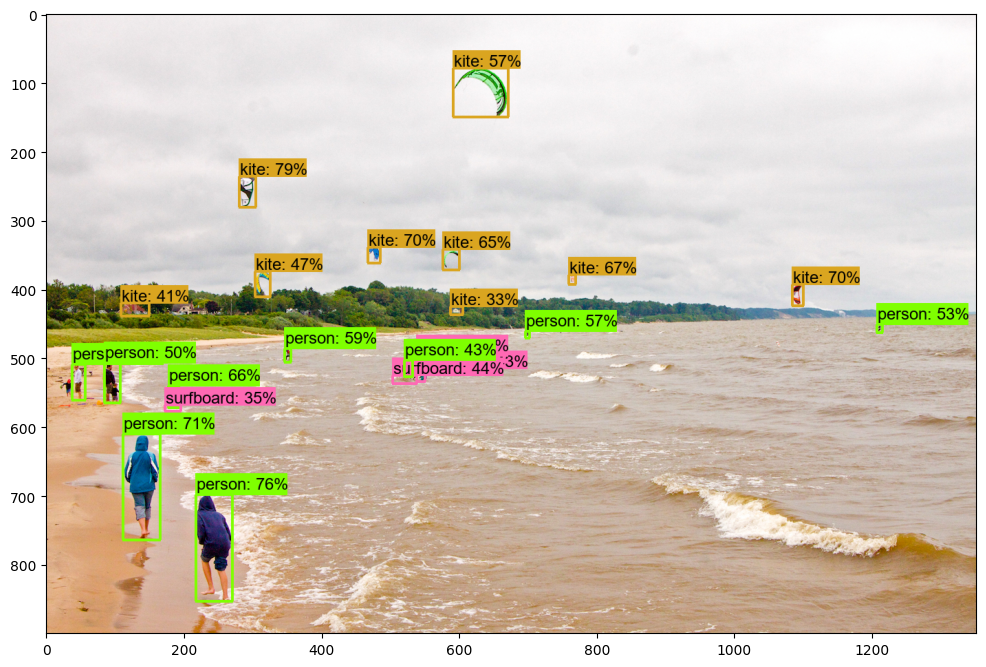

In [17]:
image_dir = 'models/research/object_detection/test_images/'
image_path = os.path.join(image_dir, 'image2.jpg')
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

# Use keypoints if available in detections
keypoints, keypoint_scores = None, None
if 'detection_keypoints' in detections:
  keypoints = detections['detection_keypoints'][0].numpy()
  keypoint_scores = detections['detection_keypoint_scores'][0].numpy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores,
      keypoint_edges=get_keypoint_tuples(configs['eval_config']))

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()
